In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "drive/My Drive/Colab Notebooks/data/image_caption_danerator"

CrowdFlowerAnnotations.txt  Flickr_8k.trainImages.txt
descriptions.txt	    __MACOSX
ExpertAnnotations.txt	    model.png
features.p		    models
Flickr8k_Dataset.zip	    README.md
Flickr_8k.devImages.txt     readme.txt
Flickr8k.lemma.token.txt    testing_caption_generator.py
Flickr_8k.testImages.txt    tokenizer.p
Flickr8k_text.zip	    training_caption_generator.ipynb
Flickr8k.token.txt


In [0]:
PATH = "drive/My Drive/Colab Notebooks/data/image_caption_danerator"

In [0]:
import os

In [0]:
print("[INFO] before changes: ", os.getcwd())
os.chdir(PATH)
print("[INFO] after changes: ", os.getcwd())

[INFO] before changes:  /content
[INFO] after changes:  /content/drive/My Drive/Colab Notebooks/data/image_caption_danerator


## Download datasets

In [0]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [0]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [0]:
# !unzip Flickr8k_Dataset.zip

In [0]:
# ! unzip Flickr8k_text.zip

In [0]:
!ls

CrowdFlowerAnnotations.txt  Flickr8k.token.txt
descriptions.txt	    Flickr_8k.trainImages.txt
ExpertAnnotations.txt	    __MACOSX
features.p		    model.png
Flicker8k_Dataset	    models
Flickr8k_Dataset.zip	    README.md
Flickr8k_Dataset.zip.1	    readme.txt
Flickr_8k.devImages.txt     testing_caption_generator.py
Flickr8k.lemma.token.txt    tokenizer.p
Flickr_8k.testImages.txt    training_caption_generator.ipynb
Flickr8k_text.zip


## Import all the necessary packages

In [0]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Getting and performing data cleaning

In [0]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [0]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [0]:
##Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [0]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

In [0]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [0]:
dataset_text = "Flickr_8k_text"
dataset_images = "Flicker8k_Dataset"

In [0]:
#we prepare our text data
filename = "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


## Extracting the feature vector from all images

In [0]:
def extract_features(directory):
    model = Xception(include_top=False, pooling="avg")
    features = {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + "/" + img 
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        # image = preprocess_input(image)
        image = image/127.5
        image = image - 1.0

        feature = model.predict(image)
        features[img] = feature 
    return features

In [0]:
# 2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p", "wb"))

83689472/83683744 [==============================] - 8s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


# Loading dataset for tranningthe model 

In [0]:
features = load(open("features.p","rb"))

In [0]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):   
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [0]:
filename = "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

## Tokenizing the vocabulary

In [0]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary 

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [0]:
# give each word a index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7577

In [0]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

In [0]:
features['1000268201_693b08cb0e.jpg'][0]

array([0.47339654, 0.01732624, 0.07333967, ..., 0.08559025, 0.02102298,
       0.23766519], dtype=float32)

## Create Data generator


In [0]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]         

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [0]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

## Defining the CNN-RNN model

In [0]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

## Training the model

In [47]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
try:
  os.mkdir("models")
except:
  pritn("dir models exist")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 256)      1939712     input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_6[0][0]      

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
6000/6000 [==============================] - 868s 145ms/step - loss: 4.4730
Epoch 1/1
6000/6000 [==============================] - 866s 144ms/step - loss: 3.6256
Epoch 1/1
6000/6000 [==============================] - 870s 145ms/step - loss: 3.3410
Epoch 1/1
6000/6000 [==============================] - 871s 145ms/step - loss: 3.1709
Epoch 1/1
6000/6000 [==============================] - 867s 144ms/step - loss: 3.0523
Epoch 1/1
6000/6000 [==============================] - 864s 144ms/step - loss: 2.9666
Epoch 1/1
6000/6000 [==============================] - 874s 146ms/step - loss: 2.8919
Epoch 1/1
6000/6000 [==============================] - 857s 143ms/step - loss: 2.8389
Epoch 1/1
6000/6000 [==============================] - 857s 143ms/step - loss: 2.7947
Epoch 1/1
6000/6000 [==============================] - 857s 143ms/step - loss: 2.7571


## Testing the model

In [64]:
!wget https://assets.imagineforest.com/blog/wp-content/uploads/2017/09/10-Garden-Games-You-Must-Play-With-Your-Kids_1.jpg

--2020-04-24 14:00:19--  https://assets.imagineforest.com/blog/wp-content/uploads/2017/09/10-Garden-Games-You-Must-Play-With-Your-Kids_1.jpg
Resolving assets.imagineforest.com (assets.imagineforest.com)... 84.17.37.209
Connecting to assets.imagineforest.com (assets.imagineforest.com)|84.17.37.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64460 (63K) [image/jpeg]
Saving to: ‘10-Garden-Games-You-Must-Play-With-Your-Kids_1.jpg’

10-Garden-Games-You 100%[===================>]  62.95K  --.-KB/s    in 0.03s   

2020-04-24 14:00:20 (2.45 MB/s) - ‘10-Garden-Games-You-Must-Play-With-Your-Kids_1.jpg’ saved [64460/64460]



In [0]:
import matplotlib.pyplot as plt

In [0]:
img_path = "10-Garden-Games-You-Must-Play-With-Your-Kids_1.jpg"

In [0]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
      if index == integer:
         return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "





start little boy in red shirt is running through the grass end


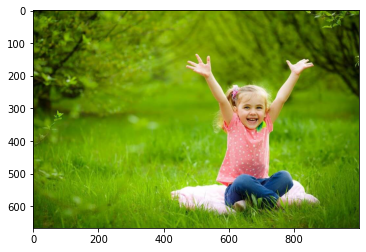

In [67]:
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [0]:
import matplotlib

In [80]:
matplotlib.__version__

'3.2.1'